# Assigment 2 

In this assigment we will work on a regression algorithm for predicting the stock price on a specific date.

https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Imports

In [518]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Read data from csv
### We read the file using pandas to 

In [519]:
df = pd.read_csv("../data/TSLA.csv")  # Read from file, (comma is the default)
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [520]:
# Check if we have any null values in our dataset
print(f"Any null values? {df.isnull().values.any()}")
df.info()  # Check the types for values

Any null values? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2845 non-null   object 
 1   Open       2845 non-null   float64
 2   High       2845 non-null   float64
 3   Low        2845 non-null   float64
 4   Close      2845 non-null   float64
 5   Adj Close  2845 non-null   float64
 6   Volume     2845 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.7+ KB


We can see that the date column is not recognised, we need to convert it to the right type

## Clean and convert the data

In [521]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert from string to datetime
df = df.set_index('Date')  # Set the date to be the index 
print(df.head())

             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


## See correlations if any

In [522]:
#df.corr()
#sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")  #Seaborn plot


We can see that Close and Adj Close is the same ^

In [523]:
df = df.drop(['Adj Close'], axis='columns')  # Drop the 'Adj Close' column

### Visualize the data

Text(0.5, 1.0, 'TSLA - Closing price')

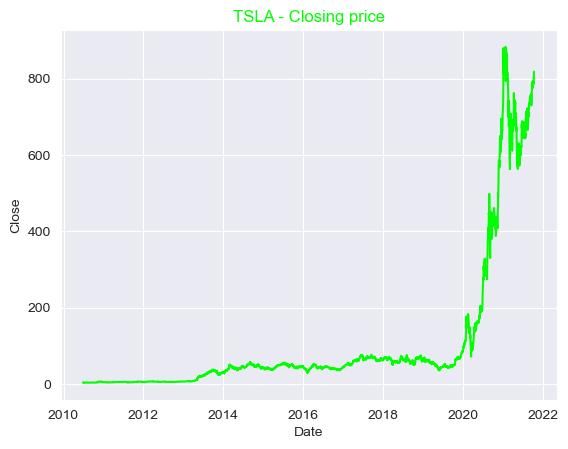

In [524]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

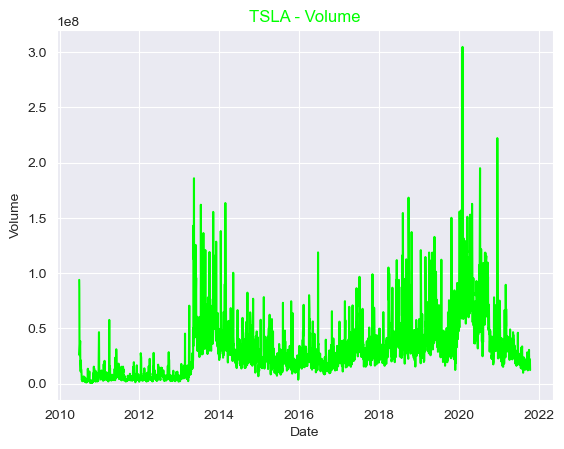

In [525]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Check distribution using boxplots

Text(0.5, 1.0, 'TSLA - Distribution of closing price ')

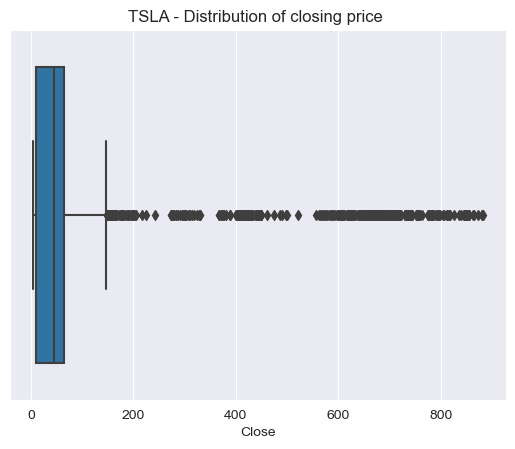

In [526]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price ")

We can observe outliers significantly distant from the upper quartiles, to fix this we can remove the outliers that fall outside the top 75 % and lower 25 % 

## Remove outliers

In [527]:
# Calculate the IQR for closing price
Q1 = df['Close'].quantile(0.25)  # Lower half
Q3 = df['Close'].quantile(0.75)  # Upper half
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows outside the bounds
df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

### Check distribution after removing outliers

Text(0.5, 1.0, 'TSLA - Distribution of closing price after removing outliers')

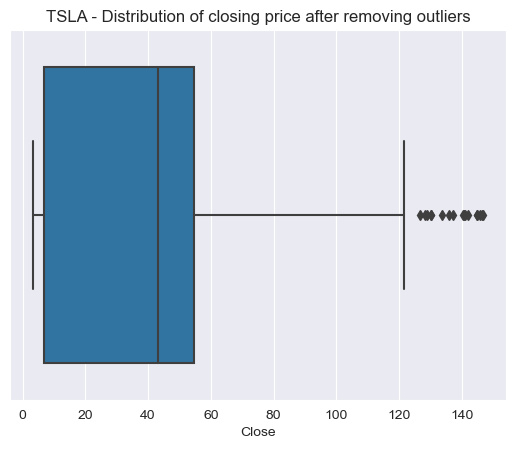

In [528]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price after removing outliers")

We can see now that the distribution is much better, we only have some outliers. 

### Visualize the data after removing outliers

Text(0.5, 1.0, 'TSLA - Closing price')

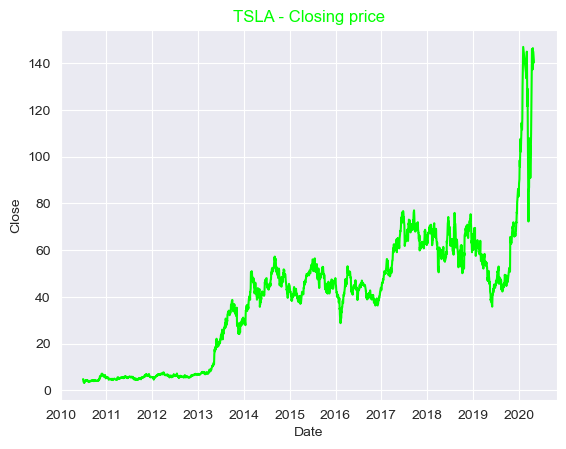

In [529]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

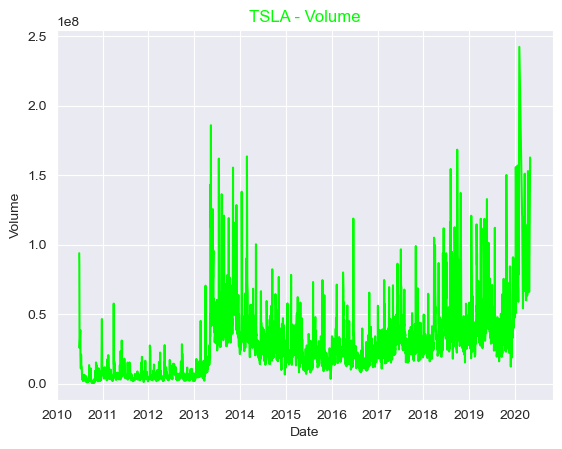

In [530]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Train the model

## Splitting the training and testing set

In [531]:
# Based on https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Change this value to set a different test size
test_size = 0.33

train_size = int(len(df) * (1 - test_size))  # Calculate how large portion that should be used for testing. 

# Take training data from the start of the dataframe, then use the rest for testing data
train_data, test_data = df[0:train_size], df[train_size:]
train_data, test_data = train_data['Close'], test_data['Close']  # Train and test from the Close column 

In [532]:
# Initial data setup
training_history = [x for x in train_data]  # Create a copy of the training data
y = test_data
predictions = []
"""
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()


pickle.dump(model, open("TSLA-SARIMAX.cc", 'wb'))"""

model = pickle.load(open("TSLA-ARIMA.cc", 'rb'))

results = model.fit()

max_length = len(df) + 1000

print(max_length)

#print(results.forecast(steps=1000))
predictions = results.predict(start=max_length, end=max_length + 1)

print(predictions)

"""
# Rolling forecasts
for i in range(len(y)):
    # Make a one-step-ahead forecast
    forecasted_value = results.forecast()[0]

    # Append the forecasted value to the predictions list
    predictions.append(forecasted_value)
"""

#df['forecast'] = results.predict(start=90, end=103, dynamic=True)
#df['forecast'] = predictions
#df[['Close', 'forecast']].plot(figsize=(12, 8))

"""

arima_order = (1, 1, 0)  # ARIMA model order
model = None  # This is defined here, so we can use the same ARIMA model after training.

# Rolling forecasts
for i in range(len(y)):
    # Initialize the model with the training history and the arima order set
    model = ARIMA(training_history, order=arima_order)

    #Train the ARIMA model
    model_fit = model.fit()

    # Make a one-step-ahead forecast
    forecasted_value = model_fit.forecast()[0]

    # Append the forecasted value to the predictions list
    predictions.append(forecasted_value)

    # Update the training history with the observed value
    training_history.append(y[i])

"""

3452
[145.12539821 145.12539821]


'\n\narima_order = (1, 1, 0)  # ARIMA model order\nmodel = None  # This is defined here, so we can use the same ARIMA model after training.\n\n# Rolling forecasts\nfor i in range(len(y)):\n    # Initialize the model with the training history and the arima order set\n    model = ARIMA(training_history, order=arima_order)\n\n    #Train the ARIMA model\n    model_fit = model.fit()\n\n    # Make a one-step-ahead forecast\n    forecasted_value = model_fit.forecast()[0]\n\n    # Append the forecasted value to the predictions list\n    predictions.append(forecasted_value)\n\n    # Update the training history with the observed value\n    training_history.append(y[i])\n\n'

### Show the results

In [533]:
"""
plt.figure(figsize=(32, 16))
plt.plot(test_data.index, y, color="red", label="Real closing price")
plt.plot(test_data.index, predictions, color='blue', label='Predicted closing price')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.show()

mse = mean_squared_error(y, predictions)
"""

'\nplt.figure(figsize=(32, 16))\nplt.plot(test_data.index, y, color="red", label="Real closing price")\nplt.plot(test_data.index, predictions, color=\'blue\', label=\'Predicted closing price\')\nplt.title(\'TSLA Stock Price Prediction\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'TSLA Stock Price\')\nplt.show()\n\nmse = mean_squared_error(y, predictions)\n'

In [534]:
"""
print(f"Mean squared error: {mse}")

model_fit = model.fit()
# Forecast
print(model_fit.forecast()[0])  # is 205.63339079331718

filename = "TSLA-ARIMA.cc"
pickle.dump(model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
model_fit = loaded_model.fit()

# Forecast
print(model_fit.forecast()[0])  # Should be and is 205.63339079331718

"""

'\nprint(f"Mean squared error: {mse}")\n\nmodel_fit = model.fit()\n# Forecast\nprint(model_fit.forecast()[0])  # is 205.63339079331718\n\nfilename = "TSLA-ARIMA.cc"\npickle.dump(model, open(filename, \'wb\'))\n\nloaded_model = pickle.load(open(filename, \'rb\'))\nmodel_fit = loaded_model.fit()\n\n# Forecast\nprint(model_fit.forecast()[0])  # Should be and is 205.63339079331718\n\n'